In [1]:
from mistralai import Mistral
import numpy as np
import faiss
import nltk
import os
import matplotlib.pyplot as plt
from typing import List

### Helper functions

In [2]:
def split_text_into_chunks(text: str, split_approach: str="sentences", chunk_size: int=12) -> List[str]:

    text = text.replace("\n", " ")
    
    if split_approach == "sentences":
        tokens = nltk.tokenize.sent_tokenize(text)
        join_char = " "

    elif split_approach == "words":
        tokens = nltk.tokenize.word_tokenize(text)
        join_char = " "
        
    elif split_approach == "chars":
        tokens = list(text)
        join_char = ""
        
    else:
        raise NotImplementedError("Split approach not supported: {}".format(split_approach))

    number_of_tokens = len(tokens)
    chunks = []
    index = 0
    
    while index + chunk_size < number_of_tokens:
        chunks.append(join_char.join(tokens[index:index + chunk_size]))
        index += chunk_size

    if index < number_of_tokens:
        chunks.append(join_char.join(tokens[index:]))
    
    return chunks

In [3]:
def get_text_embedding(text: str, client: Mistral):
    embeddings_batch_response = client.embeddings.create(
          model="mistral-embed",
          inputs=text)
    return embeddings_batch_response.data[0].embedding

In [4]:
def generate_prompt(context: str, question: str) -> str:
    prompt = f"""
    Context information is below:
    ----------------------------------------------------------------
    {context}
    ----------------------------------------------------------------
    Given the context information above, and without using prior knowledge, answer the query asked below.
    ----------------------------------------------------------------    
    Query: {question}
    """
    return prompt

In [5]:
def get_response_from_prompt(prompt: str, model: str="mistral-large-latest"):
    message = [{"role": "user", "content": prompt}]
    chat_response = client.chat.complete(model=model, messages=message)
    response = chat_response.choices[0].message.content
    return response

In [6]:
api_key = os.environ["MISTRAL_API_KEY"]
client = Mistral(api_key=api_key)

### Text (First chaper of "The Great Game: On Secret Service in High Asia", by Peter Hopkirk)

In [7]:
with open("../local_datasets/the_great_game_peter_hopkirk_chaper_1_the_yellow_peril.txt", "r") as fid:
    text = fid.read()

In [8]:
question = "What did Ivan the Terrible achieve?"

### Embeddings

In [9]:
chunks = split_text_into_chunks(text=text, split_approach="sentences", chunk_size=4)

In [10]:
text_embeddings = np.array([get_text_embedding(text=chunk, client=client) for chunk in chunks])

In [11]:
num_embeddings, embedding_dim = text_embeddings.shape
print("Number of embeddings: {}".format(num_embeddings))
print("Embeddings dimensionality: {}".format(embedding_dim))

Number of embeddings: 48
Embeddings dimensionality: 1024


In [12]:
index = faiss.IndexFlatL2(embedding_dim)
index.add(text_embeddings)

In [13]:
question_embeddings = np.array([get_text_embedding(text=question, client=client)])

In [14]:
distances_to_most_similar_vectors, indices_of_most_similar_vectors = index.search(question_embeddings, k=num_embeddings)
distances_to_most_similar_vectors = distances_to_most_similar_vectors[0]
indices_of_most_similar_vectors = indices_of_most_similar_vectors[0]

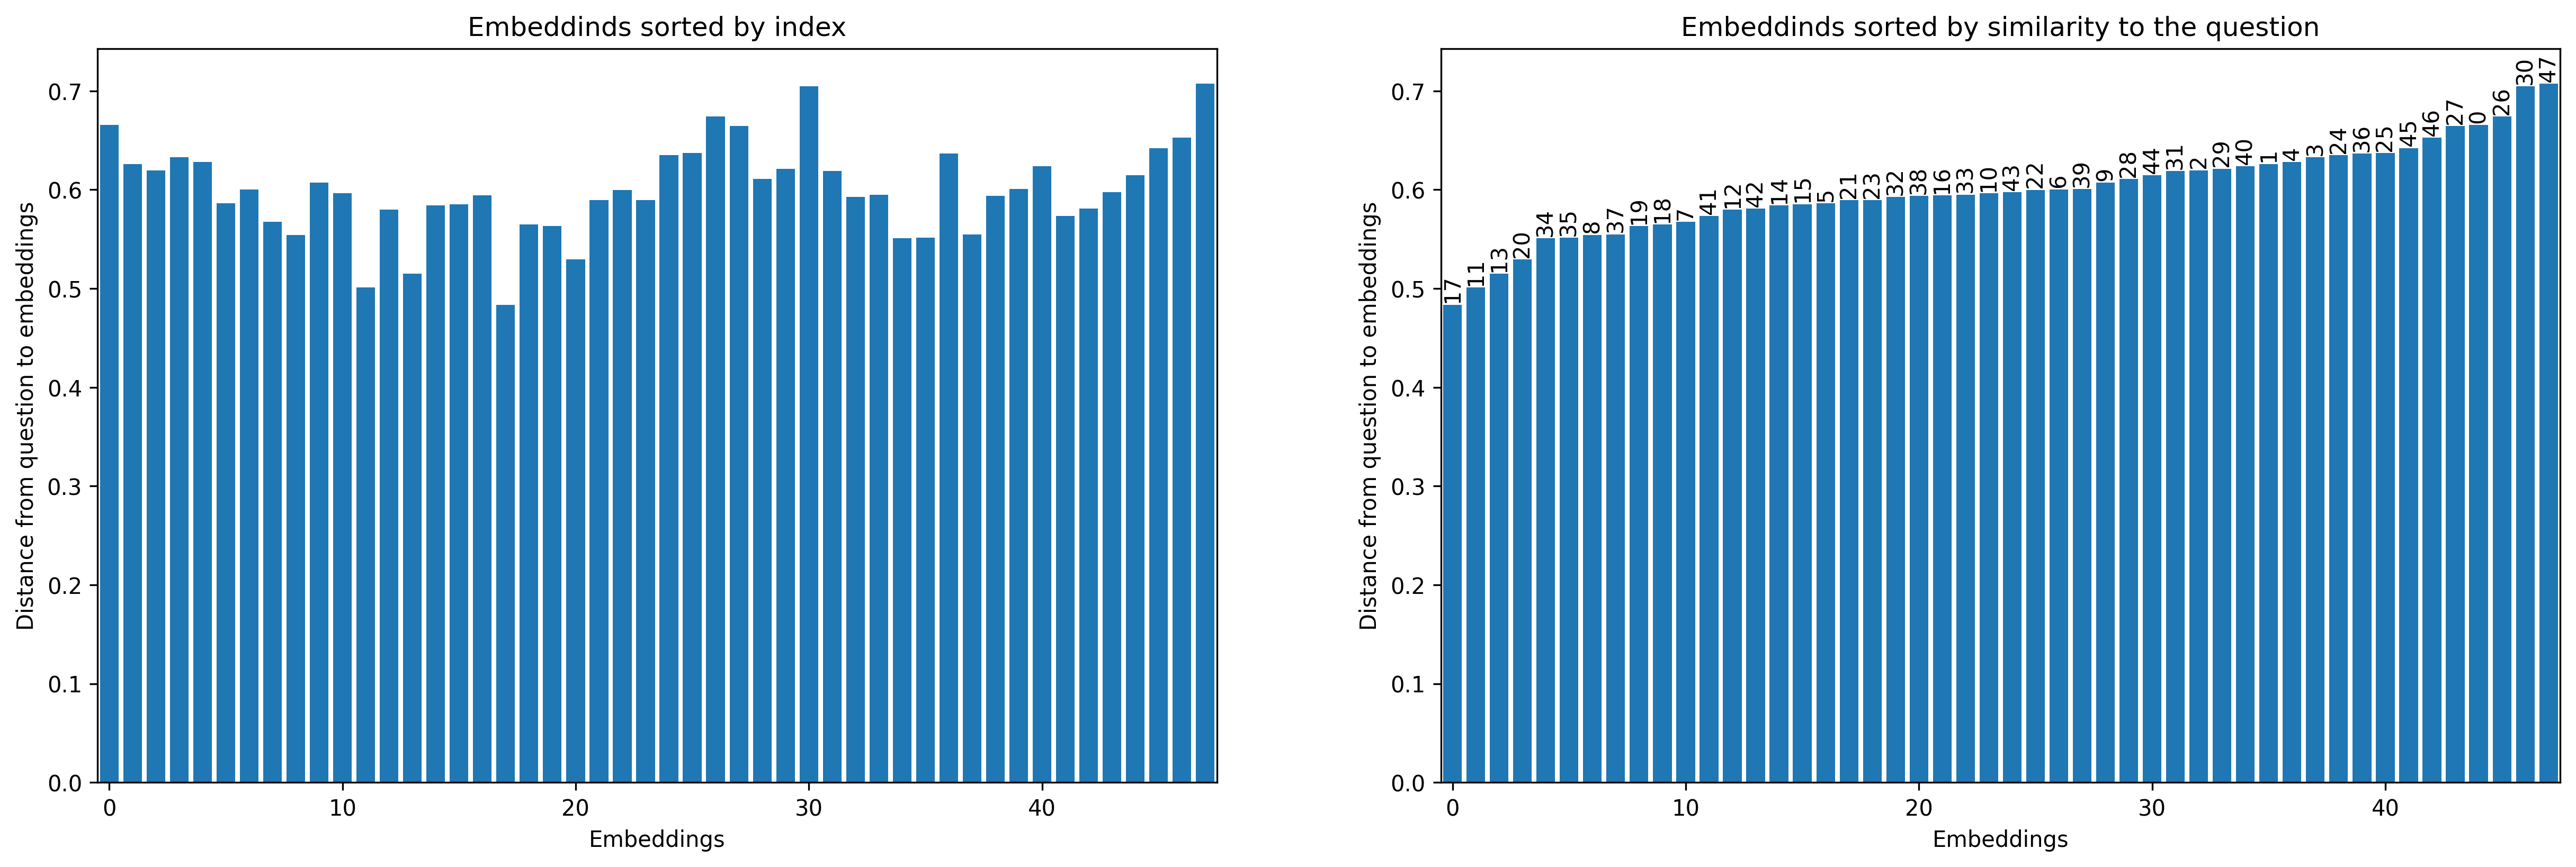

In [15]:
fig, ax = plt.subplots(1, 2)
fig.set_dpi(300)
fig.set_size_inches(20, 6, forward=True)

axx = ax[0]
fig.sca(axx)
axx.bar(indices_of_most_similar_vectors, distances_to_most_similar_vectors)
axx.set_xlim([-0.5, num_embeddings-0.5])
plt.xlabel("Embeddings")
plt.ylabel("Distance from question to embeddings")
plt.title("Embeddinds sorted by index")

axx = ax[1]
fig.sca(axx)
bar_container = axx.bar(np.arange(num_embeddings), distances_to_most_similar_vectors)
axx.bar_label(bar_container, labels=[i for i in indices_of_most_similar_vectors], padding=1, rotation=90)
axx.set_xlim([-0.5, num_embeddings-0.5])
plt.xlabel("Embeddings")
plt.ylabel("Distance from question to embeddings")
plt.title("Embeddinds sorted by similarity to the question")

plt.show()

In [16]:
index = 0
print("Most relevant chunk (distance={:.2f}):".format(distances_to_most_similar_vectors[index]))
print("-"*64)
print("Question:")
print(question)
print("-"*64)
print(chunks[indices_of_most_similar_vectors[index]])

Most relevant chunk (distance=0.48):
----------------------------------------------------------------
Question:
What did Ivan the Terrible achieve?
----------------------------------------------------------------
It fell to one of Ivan's successors, Ivan the Terrible, to seize the first two of these and incorporate them in Muscovy's rapidly expanding empire. Thirsting for revenge, his troops stormed the fortress of Kazan on the upper Volga in 1553, slaughtering the defenders just as the Mongols had done when they laid waste Russia's great cities. Two years later the Khanate of Astrakhan, where the Volga flows into the Caspian, met with a similar fate. Only the Crimea, the last remaining Tartar redoubt, still held out, and then merely because it enjoyed the protection of the Ottoman sultans, who regarded it as a valuable bulwark against the Russians.


In [17]:
index = 1
print("Second most relevant chunk (distance={:.2f}):".format(distances_to_most_similar_vectors[index]))
print("-"*64)
print("Question:")
print(question)
print("-"*64)
print(chunks[indices_of_most_similar_vectors[index]])

Second most relevant chunk (distance=0.50):
----------------------------------------------------------------
Question:
What did Ivan the Terrible achieve?
----------------------------------------------------------------
The invasions of Napoleon and Hitler, though unsuccessful, merely reinforced these fears. Only now do the Russian people show signs of shaking off this unhappy legacy. Those ferocious little horsemen whom Genghis Khan let loose upon the world have much to answer for, more than four centuries after their power was finally broken and they themselves sank back into the obscurity from which they had come. The man to whom the Russians owe their freedom from Mongol oppression was Ivan III, known also as Ivan the Great, then Grand Prince of Moscow.


In [18]:
index = -1
print("Least relevant chunk (distance={:.2f}):".format(distances_to_most_similar_vectors[index]))
print("-"*64)
print("Question:")
print(question)
print("-"*64)
print(chunks[indices_of_most_similar_vectors[index]])

Least relevant chunk (distance=0.71):
----------------------------------------------------------------
Question:
What did Ivan the Terrible achieve?
----------------------------------------------------------------
By the spring of 1798 all was ready, and on May 19 an armada carrying French troops sailed secretly from the ports of Toulon and Marseilles.


In [19]:
index = -2
print("Second least relevant chunk (distance={:.2f}):".format(distances_to_most_similar_vectors[index]))
print("-"*64)
print("Question:")
print(question)
print("-"*64)
print(chunks[indices_of_most_similar_vectors[index]])

Second least relevant chunk (distance=0.70):
----------------------------------------------------------------
Question:
What did Ivan the Terrible achieve?
----------------------------------------------------------------
Frankenburg objected, expressing his misgivings over allowing the force to be dispersed in this way. But he was overruled by Bekovich, who insisted that his order be obeyed. When Frankenburg continued to argue with him, Bekovich warned him that he would have him court-martialled when they got back if he did not do as he was told. The troops were then led away in small groups by their hosts.


### Answering a question with relevant information

In [20]:
number_of_considered_relevant_chunks = 2
relevant_chunks = ""
for index in range(number_of_considered_relevant_chunks):
    relevant_chunks += " " + chunks[indices_of_most_similar_vectors[index]]

In [21]:
prompt = generate_prompt(context=relevant_chunks, question=question)
print(prompt)


    Context information is below:
    ----------------------------------------------------------------
     It fell to one of Ivan's successors, Ivan the Terrible, to seize the first two of these and incorporate them in Muscovy's rapidly expanding empire. Thirsting for revenge, his troops stormed the fortress of Kazan on the upper Volga in 1553, slaughtering the defenders just as the Mongols had done when they laid waste Russia's great cities. Two years later the Khanate of Astrakhan, where the Volga flows into the Caspian, met with a similar fate. Only the Crimea, the last remaining Tartar redoubt, still held out, and then merely because it enjoyed the protection of the Ottoman sultans, who regarded it as a valuable bulwark against the Russians. The invasions of Napoleon and Hitler, though unsuccessful, merely reinforced these fears. Only now do the Russian people show signs of shaking off this unhappy legacy. Those ferocious little horsemen whom Genghis Khan let loose upon the world

In [22]:
response = get_response_from_prompt(prompt=prompt)
print(response)

Ivan the Terrible, one of Ivan's successors, achieved the seizure of Kazan and Astrakhan, incorporating them into Muscovy's rapidly expanding empire. Specifically, his troops stormed the fortress of Kazan on the upper Volga in 1553 and conquered the Khanate of Astrakhan two years later.


### Answering a question with irrelevant information

In [23]:
number_of_considered_irrelevant_chunks = 2
irrelevant_chunks = ""
for index in range(number_of_considered_irrelevant_chunks):
    irrelevant_chunks += " " + chunks[indices_of_most_similar_vectors[-index -1]]

In [24]:
prompt = generate_prompt(context=irrelevant_chunks, question=question)
print(prompt)


    Context information is below:
    ----------------------------------------------------------------
     By the spring of 1798 all was ready, and on May 19 an armada carrying French troops sailed secretly from the ports of Toulon and Marseilles. Frankenburg objected, expressing his misgivings over allowing the force to be dispersed in this way. But he was overruled by Bekovich, who insisted that his order be obeyed. When Frankenburg continued to argue with him, Bekovich warned him that he would have him court-martialled when they got back if he did not do as he was told. The troops were then led away in small groups by their hosts.
    ----------------------------------------------------------------
    Given the context information above, and without using prior knowledge, answer the query asked below.
    ----------------------------------------------------------------    
    Query: What did Ivan the Terrible achieve?
    


In [25]:
response = get_response_from_prompt(prompt=prompt)
print(response)

Based solely on the context information provided, there is no mention of Ivan the Terrible or his achievements. Therefore, it is not possible to answer the query about what Ivan the Terrible achieved from the given context.
